In [2]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

/Users/kvaky/anaconda3/envs/rethinking/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


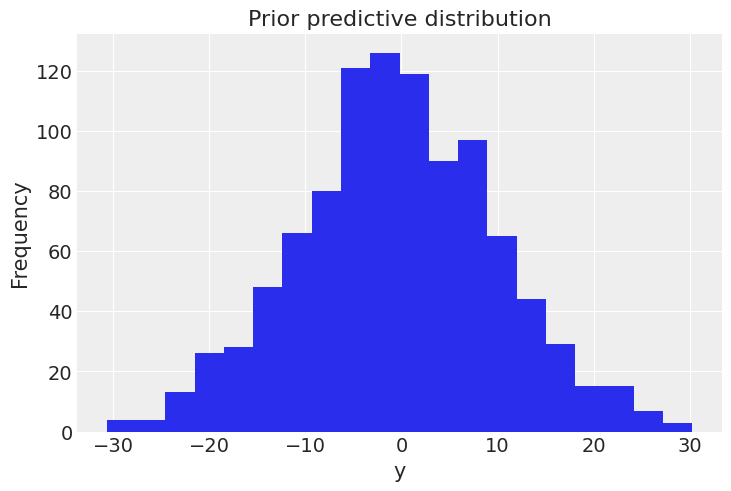

In [3]:
# yi ∼ Normal(μ, σ)
# μ ∼ Normal(0, 10) 
# σ ∼ Exponential(1)
def model():
    mu = numpyro.sample("mu", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    y = numpyro.sample("y", dist.Normal(mu, sigma))

# sample from prior
prior_predictive = Predictive(model, num_samples=1000)
prior_samples = prior_predictive(random.PRNGKey(0))
# plot prior predictive
fig, ax = plt.subplots()
ax.hist(prior_samples["y"], bins=20)
ax.set_title("Prior predictive distribution")
ax.set_xlabel("y")
ax.set_ylabel("Frequency")
plt.show()

In [8]:
data_raw = pd.read_csv("../data/Howell1.csv", sep=";")

data = data_raw[data_raw.age >= 18]

In [35]:
weight_bar = data.weight.mean()

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - weight_bar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m,
    optim.Adam(1),
    Trace_ELBO(),
    weight=data.weight.values,
    height=data.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
post = m.sample_posterior(random.PRNGKey(0), svi_result.params, (10000,))

weights = jnp.array([46.95, 43.72, 64.78, 32.59, 54.63])

sim = Predictive(m.model, post)(random.PRNGKey(2), weights, None)

height_mean = sim["mu"].mean(axis=0)

height_hdpi = hpdi(sim["height"], 0.89, axis=0)

print(height_mean)
print(height_hdpi)

100%|██████████| 2000/2000 [00:00<00:00, 7993.03it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9297]


[156.37799 153.4511  172.5348  143.36554 163.33731]
[[148.0967  145.40984 164.78192 134.985   155.25443]
 [164.58464 161.4594  181.04309 151.17339 171.68039]]


In [32]:
print(sim["mu"].min(axis=0))
print(sim["mu"].max(axis=0))

[155.33017 152.50044 169.35449 140.64148 161.43408]
[157.50285 154.5766  175.89093 145.52475 165.20746]


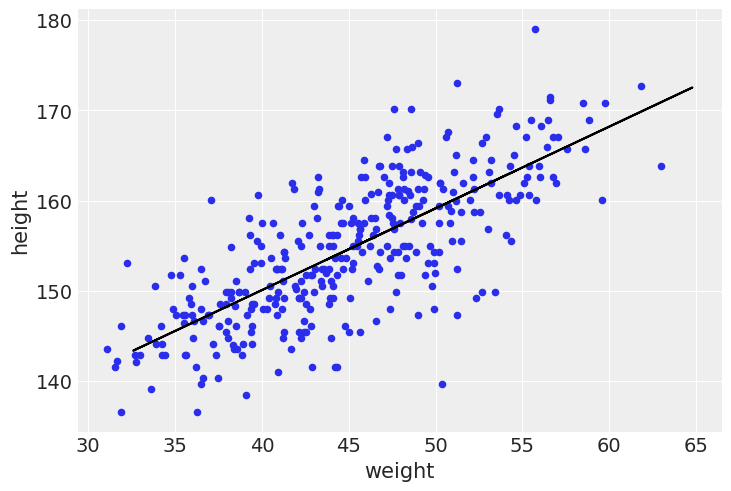

In [18]:
data.plot("weight", "height", kind="scatter")
plt.plot(weights, height_mean, "k")